In [8]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment 7 - Llama3.1 8b as a judge

In this experiment I implement the technique `LLM as judge` used in the paper `How good is my MML?` as evaluaiton metric for the correctness of the answers given by a model. The method 
consists of using a LLM to evaluate the correctness of the answers given by another model. The LLM acts as a judge by comparing the predicted answer with the ground truth answer and providing a score between 0 and 5, expressing the confidence in the answer. The judge also provides a reason for the score.


**Parameters:**
- model: llama3.1 8b
- system prompt: LLM_judge_system.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [9]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


In [10]:
predictions = []
with open('../outputs/responses_llama3.2_20250210_20:17:23.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)
predictions_df

ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'

ans_df = predictions_df['response'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
contains_ans_mask = ans_df.notna()
ans_df = ans_df[contains_ans_mask]
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_31,<NA>
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Wipe the table.
Feasibility_T6_1455,Take the shoe.


In [11]:
exact_match_pred = (ans_df['text'] == gt_df[contains_ans_mask]['text'])
exact_match_pred = exact_match_pred[ans_df['text'].notna()]
exact_match_pred.shape


(6900,)

## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [12]:
# Load the scores for the wrong answers
predictions_incorrect = []
with open('../outputs/llama8b_as_judge_wrong.jsonl') as f:
    predictions_incorrect = [json.loads(line) for line in f.readlines()]

# Load the scores for the correct answers
predictions_correct = []
with open('../outputs/llama8b_as_judge_correct.jsonl') as f:
    predictions_correct = [json.loads(line) for line in f.readlines()]

predictions = predictions_incorrect + predictions_correct

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df.set_index('id', inplace=True)
judge_pred_df = judge_pred_df.reindex(index=exact_match_pred.index)
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_13,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_14,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_32,correct,5,The predicted answer accurately identifies the...
Interaction_T1_40,incorrect,2,The predicted answer is incorrect because it s...
Interaction_T1_43,correct,5,The predicted answer matches the ground truth ...
...,...,...,...
Feasibility_T6_1453,incorrect,2,The predicted answer is close but not entirely...
Feasibility_T6_1454,incorrect,2,The predicted answer is wiping the table (acti...
Feasibility_T6_1455,incorrect,2,The predicted answer 'Take the shoe' does not ...


In [13]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 188.7 KB


In [14]:
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_13,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_14,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_32,correct,5,The predicted answer accurately identifies the...
Interaction_T1_40,incorrect,2,The predicted answer is incorrect because it s...
Interaction_T1_43,correct,5,The predicted answer matches the ground truth ...
...,...,...,...
Feasibility_T6_1453,incorrect,2,The predicted answer is close but not entirely...
Feasibility_T6_1454,incorrect,2,The predicted answer is wiping the table (acti...
Feasibility_T6_1455,incorrect,2,The predicted answer 'Take the shoe' does not ...


## Evlaution on the answers originally marked as wrong

In [15]:
pred_percentages = judge_pred_df[~exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  95.65%
correct   :   4.35%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Let's analyze some of the answers

In [16]:
idx = 'Interaction_T1_375'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Interaction_T1_375
Question: Which object was taken by the person?
Ground truth answer: The blanket.
Extracted answer: The clothes.

Original answer:

<Reasoning>
The question asks which object was taken by the person. To answer this, we need to look for a Scene-Graph that contains the relationship "holding" between the person and another object.

Upon examining the Spatio-Temporal Scene-Graphs in chronological order, I notice that the first Scene-Graph contains the relationship "holding - clothes". This suggests that the person is holding the clothes. However, we need to consider if this is the only instance where the person is taking an object.

Looking at the subsequent Scene-Graphs, I see that the pattern of the person holding the clothes continues throughout the sequence. There are no other instances where the person is seen holding another object, such as the phone, food, or towel.

Therefore, based on the information provided in the Spatio-Temporal Scene-Graphs, it appear

The model seems confident that the predicted answer mathces the ground truth but as we can see above this is not true.  
Can it be an error in the prompt? Or did the judge llm *"hallucinate"*?

In [17]:
prompts = []
with open('../data/llama3b_judged_prompts.jsonl') as f:
    prompts = [json.loads(line) for line in f.readlines()]

prompts_df = pd.DataFrame(prompts)
prompts_df.rename(columns={'qid': 'id'}, inplace=True)
prompts_df.set_index('id', inplace=True)
prompts_df


,prompt
id,
Interaction_T1_13,Please evaluate the following question-answer ...
Interaction_T1_14,Please evaluate the following question-answer ...
Interaction_T1_31,Please evaluate the following question-answer ...
Interaction_T1_32,Please evaluate the following question-answer ...
Interaction_T1_40,Please evaluate the following question-answer ...
...,...
Feasibility_T6_1453,Please evaluate the following question-answer ...
Feasibility_T6_1454,Please evaluate the following question-answer ...
Feasibility_T6_1455,Please evaluate the following question-answer ...


In [18]:
print(prompts_df.loc[idx]['prompt'])


Please evaluate the following question-answer pair:
Question: Which object was taken by the person?

Ground truth correct Answer: 
[START ANSWER]
The blanket.
[END ANSWER]

Predicted Answer:
[START PREDICTION]
<Reasoning>
The question asks which object was taken by the person. To answer this, we need to look for a Scene-Graph that contains the relationship "holding" between the person and another object.

Upon examining the Spatio-Temporal Scene-Graphs in chronological order, I notice that the first Scene-Graph contains the relationship "holding - clothes". This suggests that the person is holding the clothes. However, we need to consider if this is the only instance where the person is taking an object.

Looking at the subsequent Scene-Graphs, I see that the pattern of the person holding the clothes continues throughout the sequence. There are no other instances where the person is seen holding another object, such as the phone, food, or towel.

Therefore, based on the information pro

As we can see above, the prompt reported the ground truth accurately, thus is the model that missed completely the prediction.

---
Let's inspect more samples...

In [19]:
judged_correct_mask = (judge_pred_df[~exact_match_pred]['pred'] == 'correct')
idx = random.choice(judged_correct_mask[judged_correct_mask].index)


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Prediction_T3_147
Question: Which object would the person put down next?
Ground truth answer: The picture.
Extracted answer: The box.

Original answer:

<Reasoning>
To determine which object the person would put down next, we need to analyze the sequence of events unfolding in the scene. The person is currently holding a book and standing in front of a table. In the previous frame, they were touching a picture and standing in front of it.

Looking at the Scene-Graphs, we can see that after the person touches the picture, they put it down. Then, they pick up the box and place it on the table. However, there is no indication that they would put the box down next.

The only object that appears to be being handled by the person in a way that suggests they might put it down next is the book. The person has been holding the book since the beginning of the sequence, and it's possible that they will put it down when they are done with it.

Therefore, based on this analysis, I would choo

After manual inspecting 20 randomly selected samples from those for which the LLM decision differs from the predection obtained with the regex extraction method, I have found that both fail to some degree, therfore for samples the LLM judgment is correct meaning that the sample is wrongly misclassified by the answer extraction method. In other cases, however, the judge LLM wrongly classifies the prediction of the predictor LLM as correct even tough it does not match the ground truth.

TODO: Try moving the ground truth part in the system part, pervious experiments have shown that the LLM tends to follow what is in the system prompt more strictly.

In [20]:
actually_correct = [
'Prediction_T3_819', 
'Sequence_T5_2830', 
'Sequence_T3_5266', 
'Interaction_T1_2063', 
'Sequence_T2_1682', 
'Sequence_T1_3189', 
'Sequence_T4_2776', 
'Interaction_T2_3880', 
'Sequence_T1_3074', 
'Sequence_T2_51', 
'Sequence_T3_1340'
]

actually_wrong = [
'Sequence_T3_96',
'Sequence_T6_3840',
'Prediction_T2_1112',
'Prediction_T2_476',
'Prediction_T4_1644',
'Interaction_T2_2489',
'Sequence_T4_3651',
'Interaction_T2_2623',
'Sequence_T3_3359'
]


---
In the following example, the answer given by the predictor is correct, as the ultimate answer given by model matches the ground-truth, extraction pipeline in not able to handle such cases, as it matches only the first instance where the regex matches.

In [21]:
idx = 'Prediction_T3_819'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Prediction_T3_819
Question: Which object would the person take next?
Ground truth answer: The shoe.
Extracted answer: The clothes.

Original answer:

<Reasoning>
To determine which object the person would take next, we need to analyze the sequence of events unfolding in the video. The Scene-Graphs represent the static symbolic representation of the scene at each frame.

From the given Spatio-Temporal Scene-Graphs, we can see that the person is initially lying on the sofa/couch and then gets up to touch the sofa/couch. After that, they sit down on the sofa/couch again. The next event in the sequence is that the person touches the sofa/couch while sitting on it.

However, there is no direct mention of the person picking up an object after touching the sofa/couch. But we can see that the person is holding a shoe and has it in front of them. This suggests that the person might be preparing to take the shoe next.

Therefore, based on this analysis, I would choose:

A: 2. The clothes.

---
Below the model makes arrives at the correct conclusion, but makes an error in reporting the answer, chossing completely another answer.

In [22]:
idx = 'Sequence_T5_2830'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T5_2830
Question: What did the person do to the clothes after opening the closet/cabinet?
Ground truth answer: Took.
Extracted answer: Threw.

Original answer:

<Reasoning>
To answer this question, we need to analyze the sequence of events unfolding in the scene. The person is first seen holding clothes and standing in front of a closet/cabinet (Scene-Graph 1). Then, they are still holding clothes but now also holding a bag and standing in front of it (Scene-Graph 2). This suggests that the person took something out of the closet/cabinet.

Next, we see the person holding both the bag and the clothes again, with the bag now on the side (Scene-Graph 3). This implies that the person put the bag down. However, this is not a conclusive evidence as it could be just a temporary placement.

The next Scene-Graph shows the person touching the bag, which suggests that they are handling it actively (Scene-Graph 4). This indicates that the person did something to the bag after takin

---
Here is seems that the judge completely overlooks the grount truth answer and looks only at the soundeness of the reasoning given by the predictor.

In [23]:
idx = 'Sequence_T3_96'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T3_96
Question: What happened after the person opened the book?
Ground truth answer: Took the paper/notebook.
Extracted answer: None of the above.

Original answer:

<Reasoning>
To answer this question, we need to analyze the sequence of events related to the person opening the book. The first Scene-Graph shows the person holding the book, touching the book, and being in front of the book. This suggests that the person has opened the book.

The next few Scene-Graphs show the person still holding the book, being in front of it, and also holding a paper/notebook. However, this does not necessarily mean that the person took the paper/notebook after opening the book, as they may have been holding both objects simultaneously.

Looking at the subsequent Scene-Graphs, we see that the person is still holding the book and being in front of it, but there is no mention of taking the box or putting down the sandwich. The only other object mentioned is the paper/notebook, which is n

### Distribution of confidence score

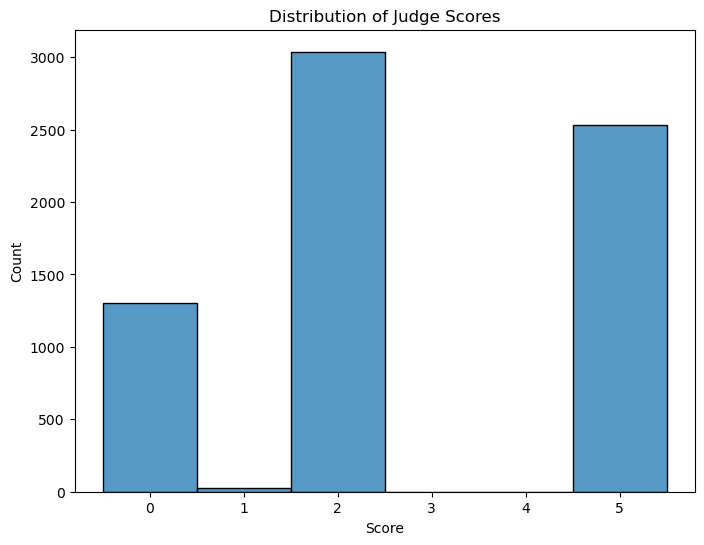

In [24]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


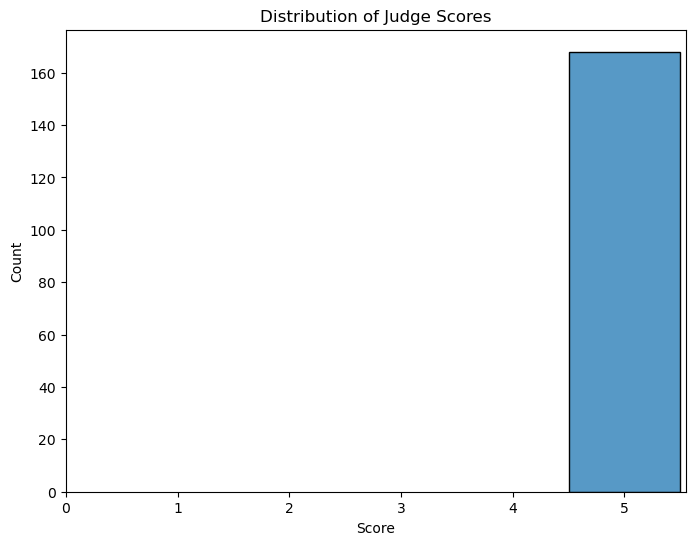

In [25]:
# Now the score distribution for the prediction which the judge considers as correct answer

plt.figure(figsize=(8, 6))
sns.histplot(data = \
             judge_pred_df \
             .loc[~exact_match_pred] \
             .loc[judged_correct_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Not good. The LLM is very confident for these set of answers, even though we have just verified that not all them are consitent with the ground truth.

## Evaluation on the answers originally marked as correct

In [26]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 446.7 KB


In [27]:
pred_percentages = judge_pred_df[exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  22.28%
correct   :  77.72%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Load the orignal model predictions to verify the judgement of the model.

In [28]:
judged_incorrect_mask = judge_pred_df[exact_match_pred]['pred'] == 'incorrect'

judge_pred_df[exact_match_pred][judged_incorrect_mask]


,pred,score,reason
id,,,
Interaction_T1_171,incorrect,2,The predicted answer is incorrect because it d...
Interaction_T1_198,incorrect,2,The predicted answer is incorrect because it r...
Interaction_T1_226,incorrect,2,The predicted answer is incorrect because it d...
Interaction_T1_298,incorrect,2,The predicted answer is incorrect because it r...
Interaction_T1_460,incorrect,2,The predicted answer is incorrect because it o...
...,...,...,...
Feasibility_T6_1090,incorrect,0,The predicted answer is incorrect because it d...
Feasibility_T6_1275,incorrect,2,The predicted answer is incorrect because it d...
Feasibility_T6_1298,incorrect,2,The predicted answer is incorrect because it a...


Let's analyze some of the answers

In [29]:
idx = 'Interaction_T1_171'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Interaction_T1_171
Question: Which object was put down by the person?
Ground truth answer: The shoe.
Extracted answer: The shoe.

Original answer:

<Reasoning>
To determine which object was put down by the person, we need to analyze the sequence of events. The person is initially wearing a shoe and standing on the floor. As they move around, their position changes, but the shoe remains in contact with the ground.

The first scene-graph shows the person wearing the shoe and standing on the floor, indicating that the shoe has not been put down yet. However, subsequent scene-graphs show the person moving towards a location where they are no longer standing on the floor, suggesting that they have placed the shoe down.

In particular, Scene-Graph 2 shows the person wearing the shoe and standing on the floor, while Scene-Graph 3 shows the person wearing the shoe and standing on the ground. This implies that the person has put the shoe down at some point between these two scenes.

The 

Actually the answer provided by the predictor is logic and sound, meanwhile the reason provided by judge are not very convinving, moreover it failed to catch that the provided answer matches the gorund truth.

Let's inspect more samples...

In [30]:
idx = random.choice(judged_incorrect_mask[judged_incorrect_mask].index)


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")



Index: Interaction_T1_7151
Question: Which object was lied on by the person?
Ground truth answer: The floor.
Extracted answer: The floor.

Original answer:

<Reasoning>
To answer this question, we need to analyze the Scene-Graphs in chronological order. The person is first touching a window and then standing in front of it.

The next relevant Scene-Graph shows that the person is lying on the floor. This indicates that the person has moved from being in front of the window to lying on the floor.

Since there are multiple instances of the person lying on the floor, we can conclude that the person was lied on by the floor at some point during this sequence.

Therefore, based on the given Scene-Graphs, the correct answer is:
A: 0. The floor.

Judge evlauation:
 - verdict: incorrect
 - score: 2
 - reason: The predicted answer is incorrect because it incorrectly states that the person was lied on by the floor at some point during the sequence The correct interpretation of the Scene-Graphs sh

### Some interesting responses

#### 1 - Incoherent behavior

In this response the predictor makes reasons about the answer and inferring the most probable answer. At the end it claims to not have enough evidence to back up its claims so it will choose an alternative answer, however it still chooses the answer it 'deduced' from reasoning. This phrasing thre off the judge.

In [31]:
idx = 'Sequence_T3_308'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")



Index: Sequence_T3_308
Question: What happened after the person held the dish?
Ground truth answer: Put down the cup/glass/bottle.
Extracted answer: Put down the cup/glass/bottle.

Original answer:

<Reasoning>
To answer this question, we need to analyze the sequence of events after the person held the dish. From the given Spatio-Temporal Scene-Graph (STSG), we can see that the person is holding the dish and in front of it. Then, they are also holding a cup/glass/bottle and drinking from it.

Looking at the STSG, there is no explicit event where the person puts down the cup/glass/bottle after holding the dish. However, we do see an event where the person touches the towel, which might be related to putting something down (although it's not explicitly stated).

The other options don't seem to follow logically from the given STSG. The person doesn't sit on the floor immediately after holding the dish, and there is no indication that they took or threw the towel.

Therefore, based on the 

#### 2 - Not so logical reasoning

Here the response is not very logical and conclusive, it's more likely that the predictor guessed the correct answer, rather then reporting one which followed from a sound reasoning process.

In [32]:
idx = 'Sequence_T2_72'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")



Index: Sequence_T2_72
Question: Which object did the person put down before they took the blanket?
Ground truth answer: The phone/camera.
Extracted answer: The phone/camera.

Original answer:

<Reasoning>
To answer this question, we need to find the object that was put down before the person took the blanket. We can do this by looking for a Scene-Graph where the person is holding the laptop and then later in the sequence, the person is holding the blanket.

Looking at the STSG, I see that there are multiple instances of the person holding the laptop, but only one instance where the person is holding the blanket after holding the laptop. This suggests that the laptop was put down before the person took the blanket.

However, we need to confirm this by looking for a Scene-Graph where the person is putting down the laptop and then immediately taking up the blanket. 

Looking at the STSG again, I see that there are multiple instances of the person touching or holding the phone/camera, but 

#### 3 - Impressive reasoning steps

This response is interesting because of the process the model used to arrive at the conclusion, it can be used as an instruction in the prompt to steer the model on how to do the reasoning.

In [33]:
idx = 'Interaction_T1_2357'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Interaction_T1_2357
Question: Which object was thrown by the person?
Ground truth answer: The clothes.
Extracted answer: The clothes.

Original answer:

<Reasoning>
To determine which object was thrown by the person, we need to analyze the sequence of events in the video. The given Spatio-Temporal Scene Graph (STSG) shows the chronological order of events.

From the STSG, we can see that there are multiple instances where the person is holding or wearing clothes, but none of these instances show the person throwing anything. However, we notice that there is an instance where the person is behind the clothes, which suggests that the clothes might have been thrown by the person.

Additionally, we also see an instance where the person is touching the clothes and wearing them, which further supports the idea that the clothes were thrown by the person.

Now, let's examine the alternatives:

* The clothes (0) are already accounted for as being held or worn by the person.
* The bag (1)

In [34]:
# A list of the answer i have examined and partitioned
judge_mistakes = [
 'Interaction_T1_7151',
 'Sequence_T4_2160',
 'Prediction_T1_814',
 'Sequence_T1_1856',
 'Sequence_T4_2859'
]

dubious_response = [
 'Sequence_T1_416',
 'Interaction_T1_171',
 'Sequence_T4_1195',
 'Sequence_T3_308',
 'Sequence_T2_72'
]


### Distribution of confidence score

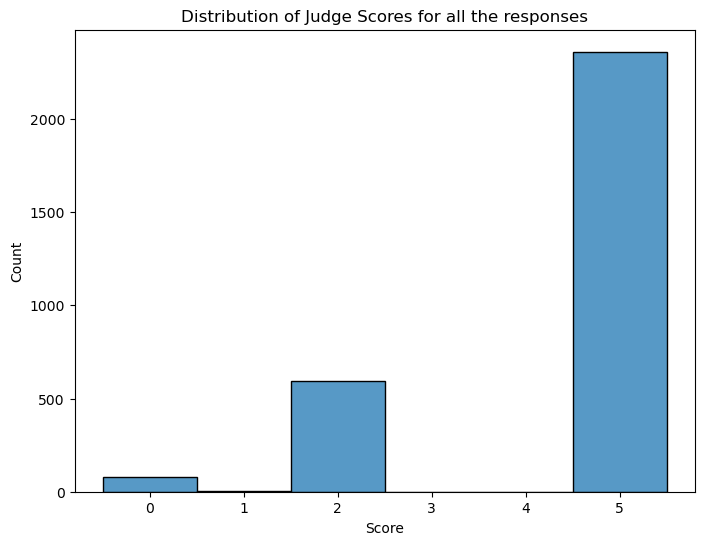

In [35]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df[exact_match_pred]['score'], discrete=True)
plt.title('Distribution of Judge Scores for all the responses')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


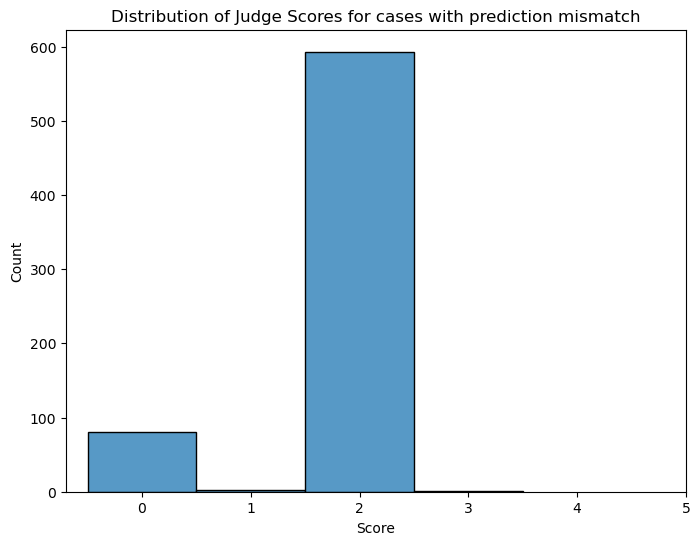

In [36]:
# Now the score distribution for the prediction which the judge considers as incorrect answers

plt.figure(figsize=(8, 6))
sns.histplot(data= \
             judge_pred_df \
             .loc[exact_match_pred]
             .loc[judged_incorrect_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores for cases with prediction mismatch')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


## Evaluation on the entire dataset

Let's do some visualization also for the ground truth data

In [37]:
judge_pred_correct_mask = (judge_pred_df['pred'] == 'correct')


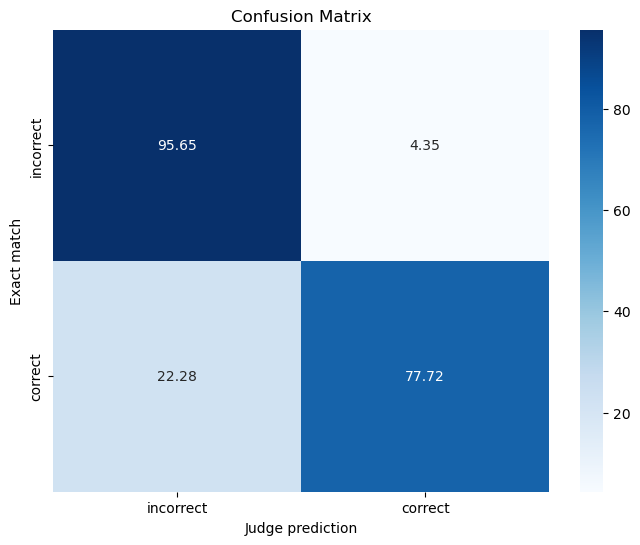

In [44]:
# Compute the confusion matrix

exact_match_labels = exact_match_pred.astype(int)
judge_pred_labels = judge_pred_correct_mask.astype(int)

cm = confusion_matrix(exact_match_labels, judge_pred_labels)

# Normalize the confusion matrix to percentage
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['incorrect', 'correct'], 
            yticklabels=['incorrect', 'correct'])
plt.xlabel('Judge prediction')
plt.ylabel('Exact match')
plt.title('Confusion Matrix')
plt.show()


In [39]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [40]:
print('LLM as a Judge accuracy\n')
print_acc(judge_pred_correct_mask, lambda x: x.sum()/x.shape[0])


LLM as a Judge accuracy

Question type       Total      Accuracy 

Interaction         2308        34.45%  
Sequence            3485        37.45%  
Prediction           621        39.94%  
Feasibility          486        37.24%  


In [41]:
print('Answer extraction through regex accuracy\n')
print_acc(exact_match_pred, lambda x: x.sum()/x.shape[0])


Answer extraction through regex accuracy

Question type       Total      Accuracy 

Interaction         2308        43.93%  
Sequence            3485        44.33%  
Prediction           621        42.67%  
Feasibility          486        44.03%  
